In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from scipy.stats import *
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # informative statistical graphics.
import statsmodels.api as sm #for ARIMA and SARIMAX
import datetime
from datetime import timedelta


sns.set_style('darkgrid') #

In [2]:

train = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')

#DF = DF[:-1]
# train = train[:-1]

train['Date'] = pd.to_datetime(train['Date'], format="%d-%b-%y")

train.tail()

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
1786,2021-10-30,2021-10-30,Recovered,14672,1,535,10,371,2,2,...,27,1,3,1172,191,8,9,6,880,0
1787,2021-10-30,2021-10-30,Deceased,445,0,2,0,4,0,0,...,1,0,0,14,1,0,0,0,13,0
1788,2021-10-31,2021-10-31,Confirmed,12907,0,385,1,212,8,5,...,26,2,21,1009,121,12,6,5,914,0
1789,2021-10-31,2021-10-31,Recovered,13152,0,675,9,236,9,3,...,25,2,8,1183,183,2,6,9,913,0
1790,2021-10-31,2021-10-31,Deceased,251,0,4,0,1,0,0,...,1,0,1,19,1,0,0,0,15,0


In [3]:

#Since we are predicting total cases ('TT') column we don't need state data ,  hence droping out state data

cols = ['AN','AP',	'AR',	'AS',	'BR',	'CH',	'CT',	'DD',	'DL',	'DN',	'GA',	'GJ',	'HP',	'HR',	'JH', 'JK',	'KA',	'KL',	'LA',	'LD',	'MH',	'ML',	'MN',	'MP',	'MZ',	'NL',	'OR',	'PB',	'PY',	'RJ',	'SK',	'TG',	'TN',	'TR',	'UP',	'UT',	'WB']
train.drop(cols, axis=1, inplace=True)
train = train.set_index('Status')
train.drop(['Recovered','Deceased'],inplace=True)
train = train.reset_index()
train.drop(["Status"],axis=1,inplace= True)

In [4]:
train.tail()

,Date,Date_YMD,TT,UN
592,2021-10-27,2021-10-27,16351,0
593,2021-10-28,2021-10-28,14307,0
594,2021-10-29,2021-10-29,14215,0
595,2021-10-30,2021-10-30,12940,0
596,2021-10-31,2021-10-31,12907,0


In [5]:

train_df = train

train_df.head()

,Date,Date_YMD,TT,UN
0,2020-03-14,2020-03-14,81,0
1,2020-03-15,2020-03-15,27,0
2,2020-03-16,2020-03-16,15,0
3,2020-03-17,2020-03-17,11,0
4,2020-03-18,2020-03-18,37,0


<AxesSubplot:xlabel='Date', ylabel='TT'>

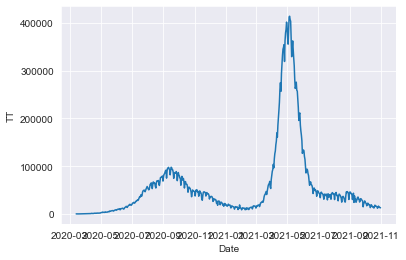

In [6]:
#plotting current data

sns.lineplot(x="Date", y="TT",legend = 'full' , data=train_df)

In [7]:

#setting 'date' column as index columna as forecasting will be done for this column
#making 'TT' as float for statistical calculations

train_df = train_df.set_index('Date')
train_df['TT'] = train_df['TT'].astype(float)

train_df.head()

,Date_YMD,TT,UN
Date,,,
2020-03-14,2020-03-14,81.0,0
2020-03-15,2020-03-15,27.0,0
2020-03-16,2020-03-16,15.0,0
2020-03-17,2020-03-17,11.0,0
2020-03-18,2020-03-18,37.0,0


<Figure size 432x288 with 0 Axes>

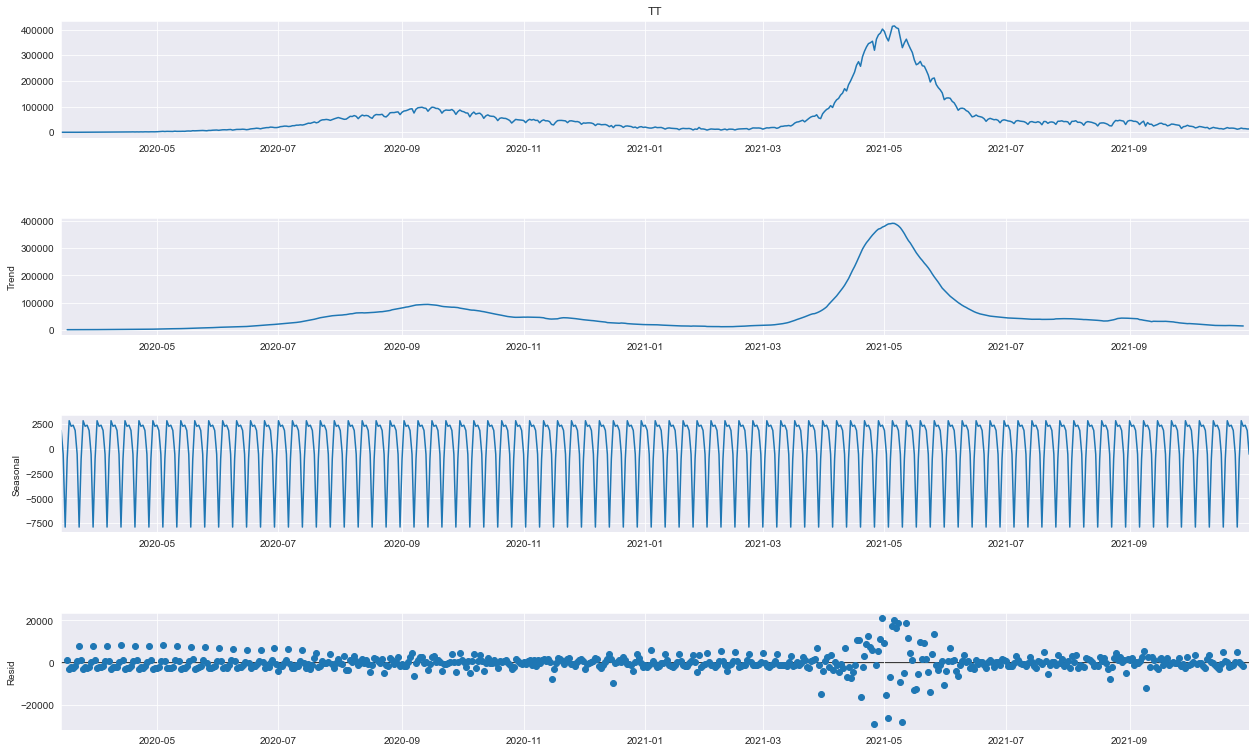

In [8]:


from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['TT'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

In [9]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The samaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

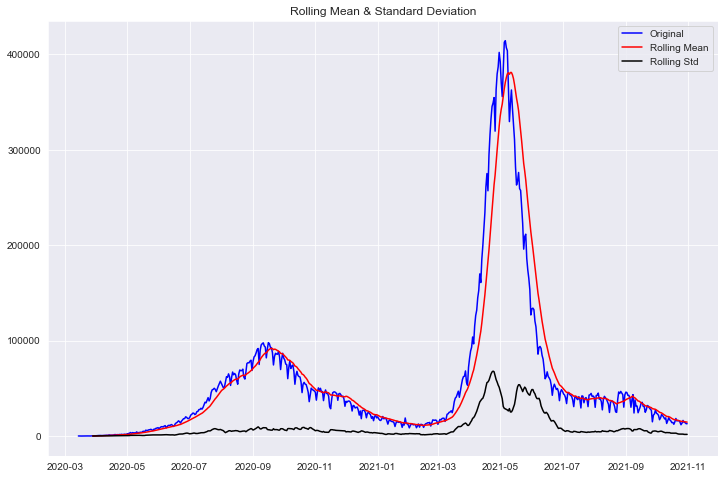

Results of Dickey-Fuller Test:
p-value = 0.0201. The series is likely non-stationary.
Test Statistic                  -3.198105
p-value                          0.020095
#Lags Used                      19.000000
Number of Observations Used    577.000000
Critical Value (1%)             -3.441734
Critical Value (5%)             -2.866562
Critical Value (10%)            -2.569445
dtype: float64


In [10]:
test_stationarity(train_df['TT'])

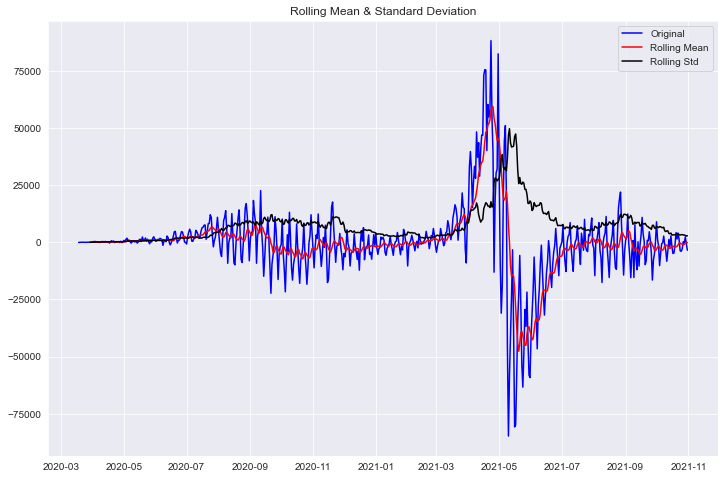

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.240639e+00
p-value                        4.706636e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.730000e+02
Critical Value (1%)           -3.441814e+00
Critical Value (5%)           -2.866597e+00
Critical Value (10%)          -2.569463e+00
dtype: float64


In [11]:
#here are various methods for making series stationary like log, differencing and so on..
#here we are using differencing , shift operator shifts the 'TT' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.3427 which is quite good as compared to our previous value 0.9778
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = train_df.TT - train_df.TT.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

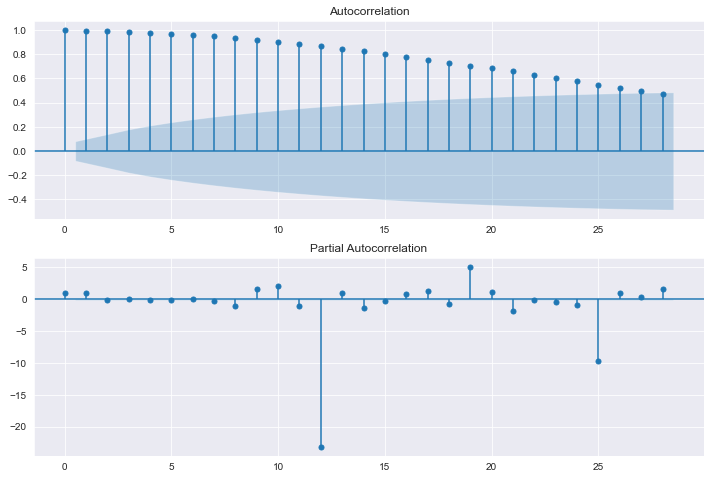

In [12]:
#plotting autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.TT, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.TT, ax=ax2) # using default value of lag

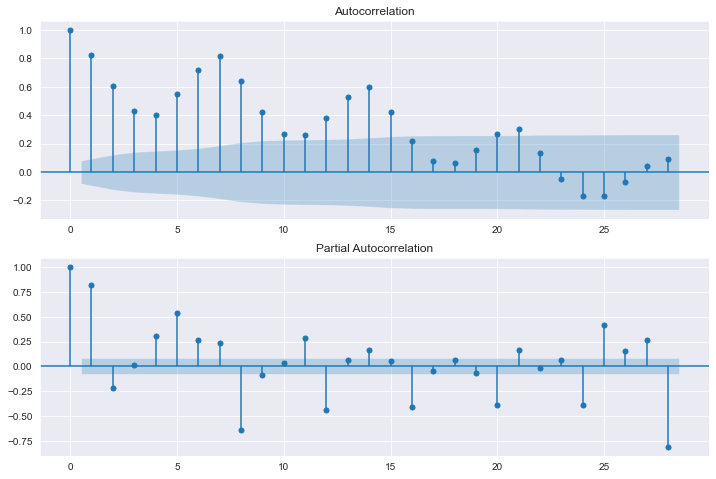

In [13]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)

In [14]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(train_df.TT, trend='n', order=(14,1,0)).fit()
print(sarimax_mod.summary())

C:\Users\RICHA\anaconda3\envs\datascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\RICHA\anaconda3\envs\datascience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                     TT   No. Observations:                  597
Model:              SARIMAX(14, 1, 0)   Log Likelihood               -5840.113
Date:                Wed, 24 Nov 2021   AIC                          11710.226
Time:                        18:40:24   BIC                          11776.079
Sample:                    03-14-2020   HQIC                         11735.869
                         - 10-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0979      0.027     -3.625      0.000      -0.151      -0.045
ar.L2          0.0975      0.027      3.675      0.000       0.045       0.149
ar.L3          0.1132      0.024      4.741      0.0

NormaltestResult(statistic=133.74209145475373, pvalue=9.083931308879309e-30)


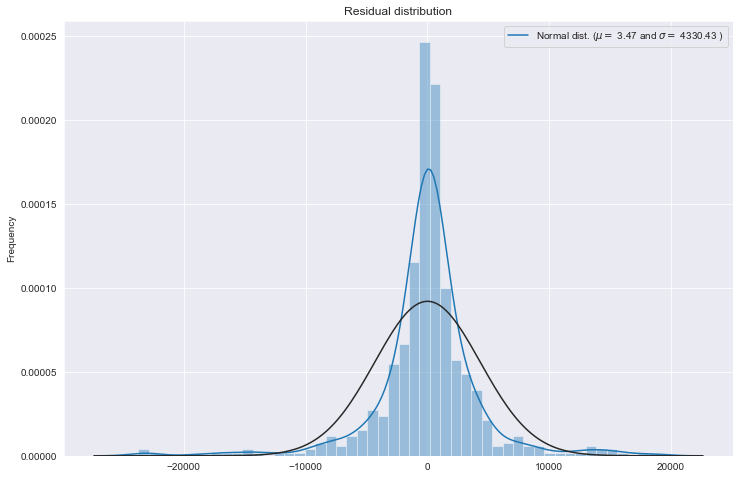

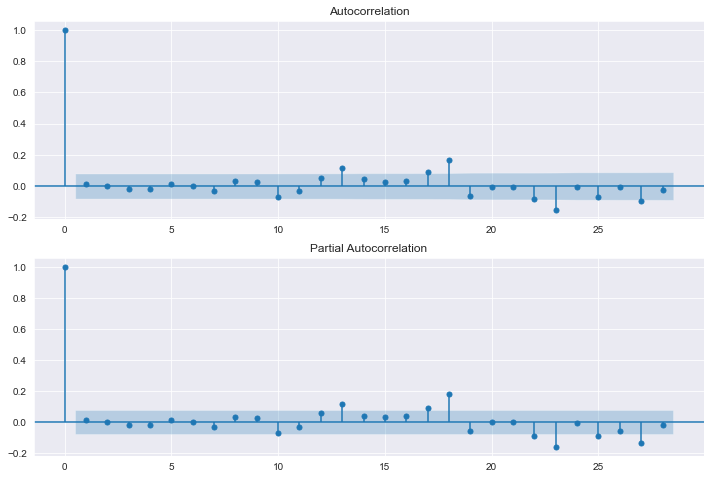

In [15]:
import scipy.stats as stats

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

<AxesSubplot:xlabel='Date'>

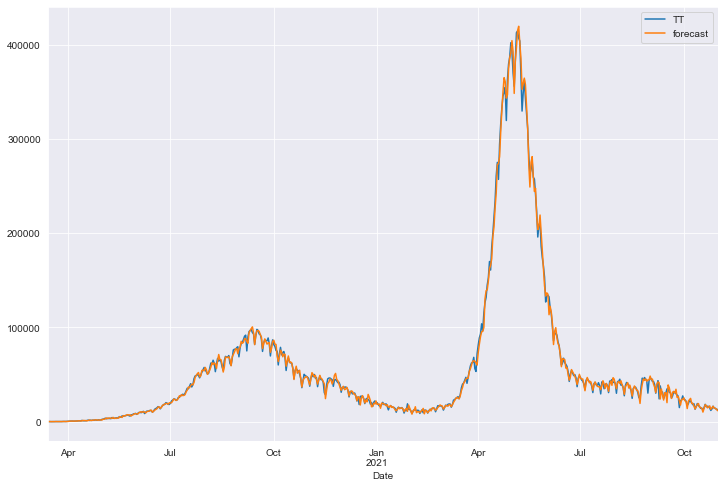

In [16]:

#Now lets predict using out model.
today = datetime.date.today() -timedelta(days=1)

start_index = '14-Mar-20'
end_index = today.strftime("%Y-%m-%d")

#adding forecasted values and plotting
train_df['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,)  

train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

In [17]:
future_predict = sarimax_mod.predict(start= datetime.date.today()-timedelta(days=14) ,end = datetime.date.today()-timedelta(days=7) ,dynamic= True,)

C:\Users\RICHA\anaconda3\envs\datascience\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [18]:

future_predict

2021-11-10    13491.591735
2021-11-11    12023.157873
2021-11-12    11681.414370
2021-11-13    11341.931738
2021-11-14    10966.767819
2021-11-15     9347.345544
2021-11-16    10988.329499
2021-11-17    12815.979287
Freq: D, Name: predicted_mean, dtype: float64

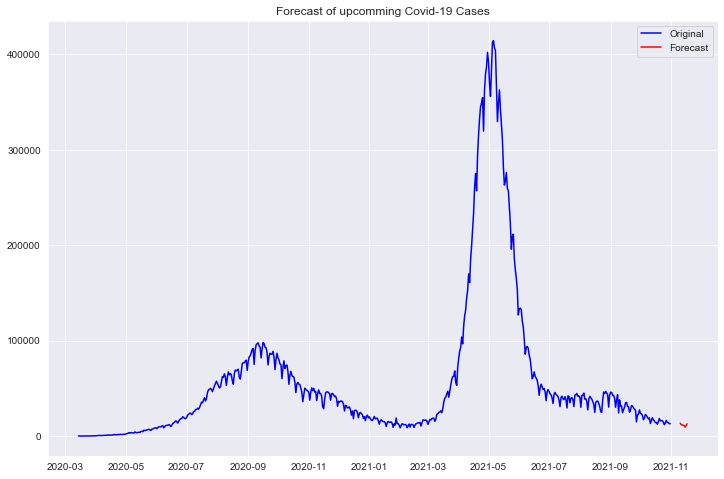

In [19]:

figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()

In [20]:

f_temp = pd.DataFrame()

In [21]:
f_temp['date'] = future_predict.index
f_temp['values'] = future_predict.values

In [22]:
f_temp

,date,values
0,2021-11-10,13491.591735
1,2021-11-11,12023.157873
2,2021-11-12,11681.414370
3,2021-11-13,11341.931738
4,2021-11-14,10966.767819
5,2021-11-15,9347.345544
6,2021-11-16,10988.329499
7,2021-11-17,12815.979287


In [23]:
f_temp.loc[-1] = [train_df.index[-1],train_df['TT'][-1]]

In [24]:
f_temp

,date,values
0,2021-11-10,13491.591735
1,2021-11-11,12023.157873
2,2021-11-12,11681.414370
3,2021-11-13,11341.931738
4,2021-11-14,10966.767819
5,2021-11-15,9347.345544
6,2021-11-16,10988.329499
7,2021-11-17,12815.979287
-1,2021-10-31,12907.000000


In [25]:

f_temp.index = f_temp.index + 1

In [26]:

#f_temp = f_temp.sort_index()
f_temp

,date,values
1,2021-11-10,13491.591735
2,2021-11-11,12023.157873
3,2021-11-12,11681.414370
4,2021-11-13,11341.931738
5,2021-11-14,10966.767819
6,2021-11-15,9347.345544
7,2021-11-16,10988.329499
8,2021-11-17,12815.979287
0,2021-10-31,12907.000000


In [27]:

# f_temp.drop(1,inplace=True)
f_temp = f_temp.sort_index()
f_temp

,date,values
0,2021-10-31,12907.000000
1,2021-11-10,13491.591735
2,2021-11-11,12023.157873
3,2021-11-12,11681.414370
4,2021-11-13,11341.931738
5,2021-11-14,10966.767819
6,2021-11-15,9347.345544
7,2021-11-16,10988.329499
8,2021-11-17,12815.979287


In [28]:
f_temp['date'] = pd.to_datetime(f_temp['date'], format="%d-%b-%y")
f_temp = f_temp.set_index('date')

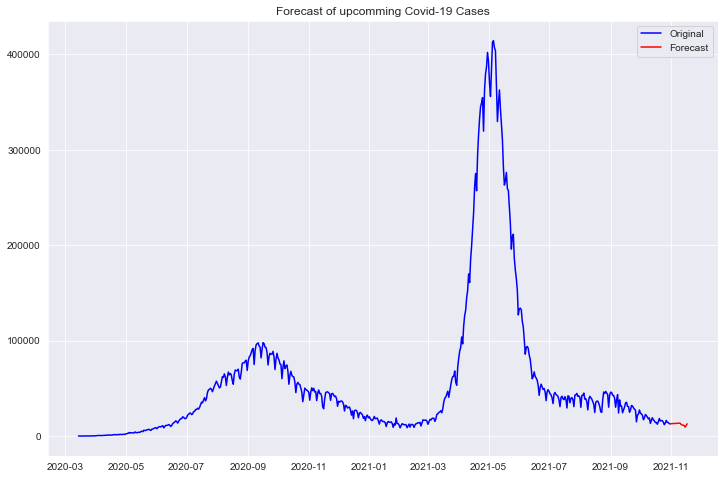

In [29]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()

In [30]:
fcast = sarimax_mod.get_forecast(datetime.date.today()+timedelta(days=7))
fcast = fcast.conf_int()
fcast

,lower TT,upper TT
2021-11-01,1740.999112,18930.980664
2021-11-02,596.697702,23747.634851
2021-11-03,150.487835,29079.498326
2021-11-04,-4552.854037,30030.076915
2021-11-05,-7484.825294,32577.392766
2021-11-06,-10950.322595,35094.197487
2021-11-07,-14907.567642,38121.903837
2021-11-08,-22765.213606,42161.595738
2021-11-09,-26275.164622,49034.450369
2021-11-10,-28844.092835,55827.276305


In [31]:
fcast = fcast.reset_index()
fcast.loc[-1] = [train_df.index[-1],train_df['TT'][-1],train_df['TT'][-1]]
fcast.index = fcast.index + 1
fcast = fcast.sort_index()
fcast['index'] = pd.to_datetime(fcast['index'], format="%d-%b-%y")
fcast = fcast.set_index('index')
fcast

,lower TT,upper TT
index,,
2021-10-31,12907.000000,12907.000000
2021-11-01,1740.999112,18930.980664
2021-11-02,596.697702,23747.634851
2021-11-03,150.487835,29079.498326
2021-11-04,-4552.854037,30030.076915
2021-11-05,-7484.825294,32577.392766
2021-11-06,-10950.322595,35094.197487
2021-11-07,-14907.567642,38121.903837
2021-11-08,-22765.213606,42161.595738


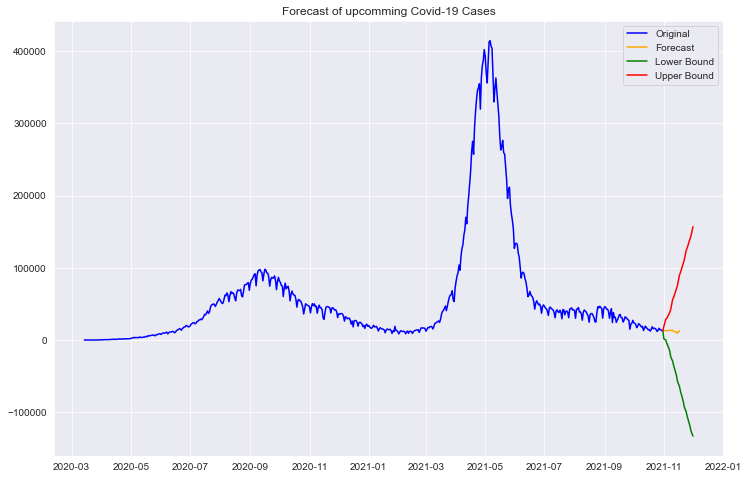

In [32]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='orange', label='Forecast')
lower = plt.plot(fcast['lower TT'], color='green', label='Lower Bound')
upper = plt.plot(fcast['upper TT'], color='red', label='Upper Bound')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Cases')
plt.show()